**Data preparation for Sentiment Analysis (SA)**

The goal is to create a proper reviews data file for further processing. 


In [1]:
spark

# Initial settings

In [2]:
%%bash
# pip3 install pandas numpy matplot seaborn
# pip3 install -U textblob
# python3 -m textblob.download_corpora lite

In [3]:
import os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Text processing related imports

import re, string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adriano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# some Spark related imports we will use hereafter

from pyspark.sql import SparkSession 
import pyspark.sql.functions as F 
from pyspark.sql.types import *

In [6]:
# Create Spark session if we want to

spark = SparkSession.builder.appName("ResettingDataPreparationSentimentAnalysis").getOrCreate()

23/07/23 20:44:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Data ingestion

In [7]:
filepath = 'data'

In [8]:
for dirname, _, filenames in os.walk(filepath):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/StoneBeach.fin.csv
data/Achlada.fin.2.csv
data/HotelJerry.fin.csv
data/aguadalma.fin.2.csv
data/FamilyHotelRelax.fin.csv
data/arolithos.fin.csv
data/HotelManili.fin.csv
data/Senator.fin.csv
data/SevenRoomsFlat.fin.csv
data/LxRossio.fin.csv
data/HotelElCami.fin.csv
data/archanes.fin.csv
data/FarmaSotira.fin.csv
data/MonteDaProvenca.csv


In [9]:
%%bash
ls -la data

total 328
drwxr-xr-x@ 16 adriano  staff    512 Jun 12 23:17 .
drwxr-xr-x  14 adriano  staff    448 Jul 23 20:42 ..
-rw-rw-r--@  1 adriano  staff  14421 Jun 14 12:36 Achlada.fin.2.csv
-rw-rw-r--@  1 adriano  staff   3885 Jun 14 12:37 FamilyHotelRelax.fin.csv
-rw-rw-r--@  1 adriano  staff   3717 Jun 14 12:39 FarmaSotira.fin.csv
-rw-rw-r--@  1 adriano  staff   4145 Jun 14 12:39 HotelElCami.fin.csv
-rw-rw-r--@  1 adriano  staff   4486 Jun 14 12:40 HotelJerry.fin.csv
-rw-rw-r--@  1 adriano  staff  16064 Jun 14 12:40 HotelManili.fin.csv
-rw-rw-r--@  1 adriano  staff   7213 Jun 14 12:40 LxRossio.fin.csv
-rw-rw-r--@  1 adriano  staff  19503 Jun 14 12:40 MonteDaProvenca.csv
-rw-rw-r--@  1 adriano  staff   5347 Jun 14 12:41 Senator.fin.csv
-rw-rw-r--@  1 adriano  staff   5975 Jun 14 12:41 SevenRoomsFlat.fin.csv
-rw-rw-r--@  1 adriano  staff   4443 Jun 14 12:41 StoneBeach.fin.csv
-rw-rw-r--@  1 adriano  staff  12314 Jun 14 12:36 aguadalma.fin.2.csv
-rw-rw-r--@  1 adriano  staff  13604 Jun 14 12:3

In [10]:
%%bash
for i in ./data/*
do
    echo ""
    echo "File: ${i}"
    head -n 2 "${i}"
    echo ""
    tail -n 1 "${i}"
    echo ""
done


File: ./data/Achlada.fin.2.csv
﻿ID;Source;Entity;Location;Country;Collection date;Review date;Review text
1683299003-58;https://www.tripadvisor.com/Hotel_Review-g14007852-d1058472-Reviews-Achlada_Mourtzanakis_Residence-Achlada_Crete.html#/media/1058472/111479167:p/?albumid=101&type=0&category=101;Mourtzanakis Residence;Achlada, Crete;Greece;05/05/2023;01/07/2022;If you are Looking for a magical vacation in nature ,with magic views of the  sea, mountains all around ,the ringing goats grazing in the meadow, and clear mountain air the…… ‏MourtzanakIs  Resort is the perfect place. ‏ It is a  calm and quiet place with a strong  presence of nature. ‏ The resort is located in an ancient village called Achlada which is about a half hour far  from Heraklion ‏ We had a small vacation unit which was quiet well equipped.  The staff was  polite and willing to help us in everything. Every request was fulfilled with a smile. ‏ The owner of the place, Marcus, is a  friendly and charming person,  with

In [11]:
# Read the data

schema = ( StructType()
          .add("ID",StringType(),True)
          .add("Source",StringType(),True)
          .add("Entity",StringType(),True)
          .add("Location",StringType(),True)
          .add("Country",StringType(),True)
          .add("Collection date",StringType(),True)
          .add("Review date",StringType(),True)
          .add("Review text",StringType(),True)
         )

df = spark.read.csv(filepath, header=True, schema=schema, sep=';')


In [12]:
# Check what has been read

df.printSchema()
reviews_count = df.count()
df.show()
reviews_count

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Collection date: string (nullable = true)
 |-- Review date: string (nullable = true)
 |-- Review text: string (nullable = true)

+--------------+--------------------+--------------------+----------------+-------+---------------+-----------+--------------------+
|            ID|              Source|              Entity|        Location|Country|Collection date|Review date|         Review text|
+--------------+--------------------+--------------------+----------------+-------+---------------+-----------+--------------------+
|1683301001-136|https://www.tripa...|Arolithos Traditi...|Heraklion, Crete| Greece|     05/05/2023| 01/10/2022|Amazing restful p...|
|1683301001-137|https://www.tripa...|Arolithos Traditi...|Heraklion, Crete| Greece|     05/05/2023| 01/10/2022|"We had lunch tod...|
|168330

201

# First clearance
Duplicates, overall nulls, get dates properly (datatypes) and to clean review text.

In [13]:
# Check duplicates

[reviews_count, df.dropDuplicates().count()]

[201, 201]

In [14]:
# Check counting with/without nulls

[reviews_count, df.dropna().count()]

[201, 201]

In [15]:
df = df.dropna()  # subset=['col name']

In [16]:
# Column names and datatypes
# .cast(DateType())
# F.to_date(...)

df = ( df
      .withColumn('Collection-date', F.to_date(F.col('Collection date'), "dd/MM/yyyy")) 
      .withColumn('Review-date', F.to_date(F.col('Review date'), "dd/MM/yyyy"))
     )

In [17]:
# Just to check stop words

stop_words = set(stopwords.words('english'))
# additional_words={'word 1', 'word 2' }
# stop_words.update(additional_words)
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [18]:
# Auxiliar UDF functions

@F.udf(returnType=IntegerType()) 
def CountWords(text):
    return len(text.split())
    
# We should improve this cleaning text function
# Removing noise

@F.udf(returnType=StringType()) 
def CleanText(text):
    regpat = re.compile(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b')
    filtered = []
    for w in text.split():
        #wrd = w.strip().lower()
        # get rid of any leading, and trailing whitespaces, and then
        # any consecutive punctuation mark by just one. ex: ... -> .
        wrd = re.sub(r'([!?,;:])\1+', r'\1', w.strip())  
        if not re.fullmatch(regpat, wrd) and wrd != ' ' and wrd != '' and '@' not in wrd:
            filtered.append(wrd)
    return ' '.join(filtered)

@F.udf(returnType=StringType()) 
def SentencesText(text):
    correct = []
    for sentence in TextBlob(text).sentences:
        for word in sentence.words:
            correct.append(' ')
            #correct.append(word.correct())  # correct function is not good, e.g we -> he
            if word not in string.punctuation:  
                correct.append(word)
            # check better since we are within the sentence
            
        correct.append('.')
    return ''.join(correct)

@F.udf(returnType=StringType()) 
def NounsText(text):  
    #from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = []
    for word in TextBlob(text).noun_phrases:
        # adjust more if needed
        # stop words, length, punctuation 
        # (maybe some tests not needed due to functions already applied)
        w = word.strip().lower()
        if w not in stop_words and len(w) > 3 and w not in string.punctuation:  # ok 3?<
            words.append(w)
    return ' '.join(words)


In [19]:
df = ( df
       .withColumn('Review-clean-text', CleanText(F.col('Review text')))
       .withColumn('Review-sentences-text', SentencesText(F.col('Review-clean-text')))
       .withColumn('Review-nouns-text', NounsText(F.col('Review-sentences-text')))
       .withColumn('Review-text-count', CountWords(F.col('Review text')))
       .withColumn('Review-sentences-text-count', CountWords(F.col('Review-sentences-text')))
       .withColumn('Review-nouns-text-count', CountWords(F.col('Review-nouns-text')))
     )

In [20]:
textcols = ['Review text', 'Review-clean-text', 'Review-sentences-text', 'Review-nouns-text', 
            'Review-text-count', 'Review-sentences-text-count', 'Review-nouns-text-count']

In [21]:
df.select(textcols).show(vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Review text                 | Amazing restful place and environment and close to many places to visit. The village is traditional and plenty of colors.  Surrounded by cats and ve

In [22]:
df.printSchema()
reviews_count = df.count()
df.show(1, vertical=True, truncate=False)
reviews_count

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Collection date: string (nullable = true)
 |-- Review date: string (nullable = true)
 |-- Review text: string (nullable = true)
 |-- Collection-date: date (nullable = true)
 |-- Review-date: date (nullable = true)
 |-- Review-clean-text: string (nullable = true)
 |-- Review-sentences-text: string (nullable = true)
 |-- Review-nouns-text: string (nullable = true)
 |-- Review-text-count: integer (nullable = true)
 |-- Review-sentences-text-count: integer (nullable = true)
 |-- Review-nouns-text-count: integer (nullable = true)



-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 ID                          | 1683301001-136                                                                                                                                                                                             
 Source                      | https://www.tripadvisor.com/Hotel_Review-g189417-d240839-Reviews-Arolithos_Traditional_Cretan_Village-Heraklion_Crete.html                                                                                 
 Entity                      | Arolithos Traditional Cretan Village                                                                                                                                                                       
 Location                    | Heraklion, Crete             

201

# Data understanding - initial EDA

In [23]:
cols_to_forget = ['Collection date', 'Review date', 'Review-clean-text']
cols_interest = [x for x in df.columns if x not in cols_to_forget]
cols_interest

['ID',
 'Source',
 'Entity',
 'Location',
 'Country',
 'Review text',
 'Collection-date',
 'Review-date',
 'Review-sentences-text',
 'Review-nouns-text',
 'Review-text-count',
 'Review-sentences-text-count',
 'Review-nouns-text-count']

In [24]:
print('\nNulls:')
for cl in cols_interest:
    if cl not in ['Collection-date', 'Review-date']:
        k = df.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count() 
        if k > 0:
            print(f'Column {cl} with {k} nulls or NaN, out of {reviews_count} records ({k*100/reviews_count:.2f}%)')


Nulls:


In [25]:
print('\nUniqueness:') 
for cl in cols_interest:
    if cl not in ['Collection-date', 'Review-date']:
        k = df.select(cl).distinct().count()
        print(f'Column {cl} with {k} distinct values, out of {reviews_count} records ({k*100/reviews_count:.2f}%)')


Uniqueness:
Column ID with 201 distinct values, out of 201 records (100.00%)
Column Source with 23 distinct values, out of 201 records (11.44%)
Column Entity with 14 distinct values, out of 201 records (6.97%)
Column Location with 14 distinct values, out of 201 records (6.97%)
Column Country with 5 distinct values, out of 201 records (2.49%)
Column Review text with 201 distinct values, out of 201 records (100.00%)
Column Review-sentences-text with 201 distinct values, out of 201 records (100.00%)
Column Review-nouns-text with 201 distinct values, out of 201 records (100.00%)
Column Review-text-count with 96 distinct values, out of 201 records (47.76%)
Column Review-sentences-text-count with 98 distinct values, out of 201 records (48.76%)
Column Review-nouns-text-count with 35 distinct values, out of 201 records (17.41%)


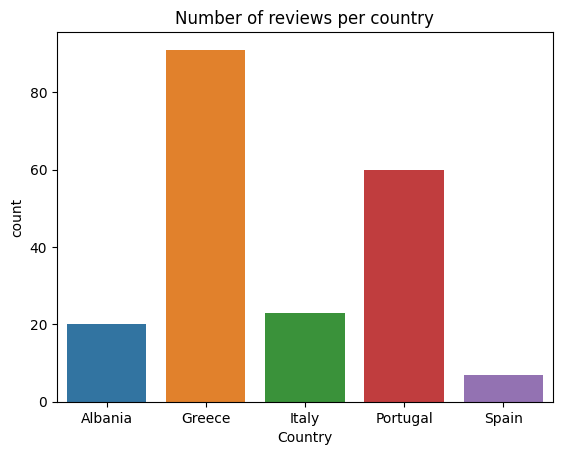

In [27]:
# How many reviews per country

df_plot = df.groupby('Country').count().sort('Country', ascending=True).toPandas()
sns.barplot(data=df_plot, x='Country', y='count')
plt.title('Number of reviews per country')
plt.show()

# Save the data of interest

In [28]:
cols_interest

['ID',
 'Source',
 'Entity',
 'Location',
 'Country',
 'Review text',
 'Collection-date',
 'Review-date',
 'Review-sentences-text',
 'Review-nouns-text',
 'Review-text-count',
 'Review-sentences-text-count',
 'Review-nouns-text-count']

In [29]:
# Save data as a parquet file

df.select(cols_interest).write.mode("overwrite").parquet("reviews")

23/07/23 20:50:58 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /private/var/folders/wl/4zhklts97ms69hcxbggp8fj00000gn/T/blockmgr-54ae5f7d-743c-4763-979c-8bb600d125d1. Falling back to Java IO way
java.io.IOException: Failed to delete: /private/var/folders/wl/4zhklts97ms69hcxbggp8fj00000gn/T/blockmgr-54ae5f7d-743c-4763-979c-8bb600d125d1
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:177)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:113)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1231)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.Indexe